In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import os
from utils import *


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# System parameters

In [4]:
# size of the region of interest
roi_size_px = 332*3
# wavelength of acquisition
lambda_m = 13.5e-9

# effective pixel size
dx_m = 15e-9
# effective field size
Dx_m = roi_size_px * dx_m

# spatial scales
x_m = np.arange(1, roi_size_px + 1) * dx_m
y_m = np.arange(1, roi_size_px + 1) * dx_m

# angular frequency scale
fs = 1 / (x_m[1] - x_m[0])
Nfft = len(x_m)
df = fs / Nfft
freq_cpm = np.arange(0, fs, df) - (fs - Nfft % 2 * df) / 2

# frequency cut-off of the lens (0.33 4xNA lens)
fc_lens = (np.arcsin(.33/4)/lambda_m)
# lens pupil filter in reciprocal space
Fx, Fy = np.meshgrid(freq_cpm, freq_cpm)
FILTER = (Fx**2 + Fy**2) <= fc_lens**2


note: df = 1/Dx_m

# Aberration parameter
Steps:
1. Decide region of interest
2. Crop ROI into patches
3. Specify each patch's aberration

In [18]:
# Load aberrations
mat = scipy.io.loadmat('./real_data/aberrations_full_FOV_angleCorrected_512.mat')
aberr_all = mat['FOV_ABERR']


del mat

mat = scipy.io.loadmat('./real_data/Fc_normalized.mat')
nFx_c = mat['nFx_c']
nFy_c = mat['nFy_c']
pupil_c = mat['pupil_c']

# Scale aberration to reasonable values rms ~ (2pi/14,2pi/2)
scale = 12
aberr_all = aberr_all*scale
scipy.io.savemat('./real_data/aberrations_full_FOV_angleCorrected_512_zernike.mat', {'FOV_ABERR':aberr_all})

In [16]:
import glob
import scipy.io as sio

folder = './sim_data/bprp_abe00'
file_path = glob.glob(f"{folder}/*APIC*.mat")
m = sio.loadmat(file_path[0])
apic_recon = m['himMatching']
pupil_recon = m['CTF_abe']
zernike_recon = m['zernikeCoeff']

(-0.5, 2987.5, 2987.5, -0.5)

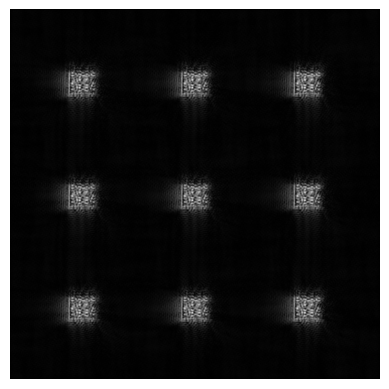

In [17]:
recon = np.abs(apic_recon)
plt.imshow(recon, cmap='gray')
plt.axis('off')

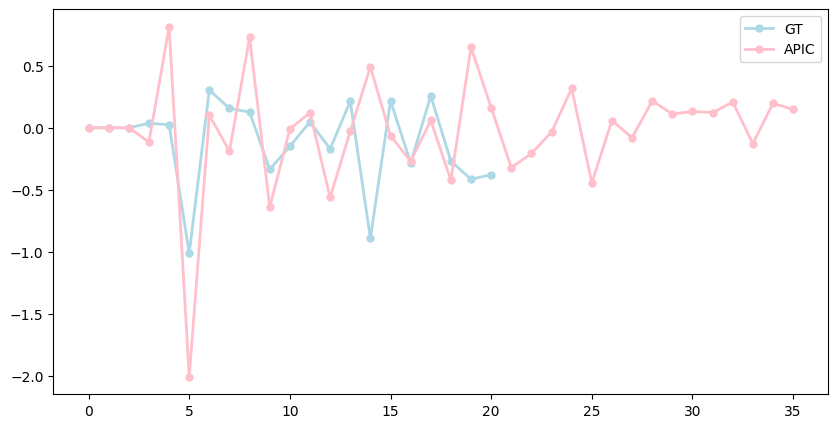

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(aberr_all[0,0].flatten(), label='GT', color='lightblue', marker='o', markersize=5, linestyle='-', linewidth=2)
plt.plot(zernike_recon.flatten(), label='APIC', color='pink', marker='o', markersize=5, linestyle='-', linewidth=2)
plt.legend()
plt.show()


Generate pupil function from Zernike coefficients

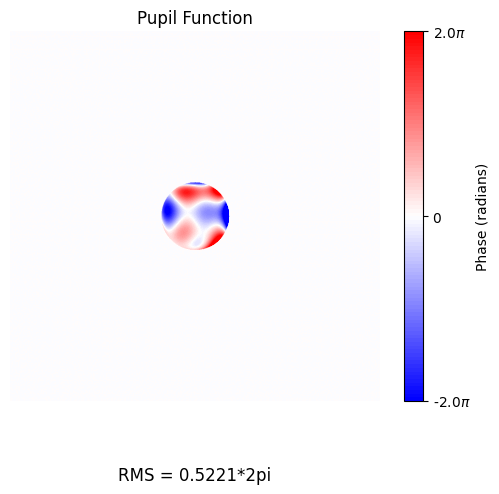

0.6362287605305278


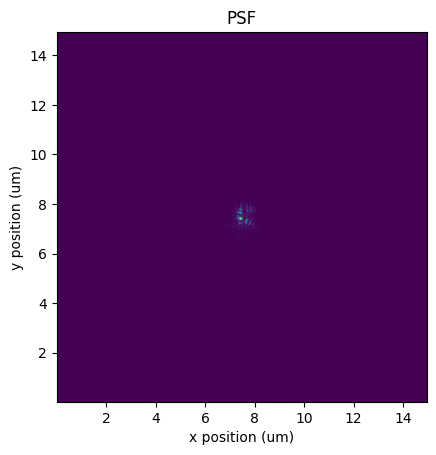

In [19]:
manual_defocus_z = np.zeros(25)
manual_defocus_z[3] = -0.2
manual_defocus_z[4] = 2
manual_defocus_z[12] = -1.5
manual_defocus_z[24] = -1
# abe_phase = get_pupil_phase(manual_defocus_z,FILTER)*2
abe_phase = get_pupil_phase(aberr_all[0,0],FILTER)*2
show_aberration(abe_phase, FILTER)
print(np.max(aberr_all[1,0]))

# Visualize PSF
abe_pupil = FILTER*np.exp(1j*abe_phase)
PSF = np.abs(np.fft.fftshift(np.fft.fft2(abe_pupil)))**2
plt.imshow(PSF, extent=[x_m[0]*1e6, x_m[-1]*1e6, y_m[0]*1e6, y_m[-1]*1e6])
plt.xlabel('x position (um)')
plt.ylabel('y position (um)')
plt.title('PSF')
plt.show()

zoom in central PSF

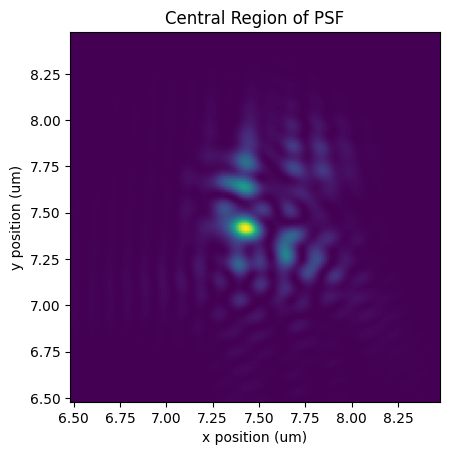

In [20]:
def plot_central_region(PSF, x_m, y_m, region_size=2e-6):
    # Extract the central region of the PSF
    x_center = (x_m[-1] + x_m[0]) / 2
    y_center = (y_m[-1] + y_m[0]) / 2
    x_indices = np.where((x_m >= x_center - region_size/2) & (x_m <= x_center + region_size/2))
    y_indices = np.where((y_m >= y_center - region_size/2) & (y_m <= y_center + region_size/2))
    central_PSF = PSF[y_indices[0][0]:y_indices[0][-1]+1, x_indices[0][0]:x_indices[0][-1]+1]

    # Plot the central region
    plt.imshow(central_PSF, extent=[x_m[x_indices[0][0]]*1e6, x_m[x_indices[0][-1]]*1e6, 
                                    y_m[y_indices[0][0]]*1e6, y_m[y_indices[0][-1]]*1e6])
    plt.xlabel('x position (um)')
    plt.ylabel('y position (um)')
    plt.title('Central Region of PSF')
    plt.show()


plot_central_region(PSF, x_m, y_m)

Create corresponding region crop functions (14\*14 patches, each 256\*256, 50% overlap)

In [7]:
# full image size
nx_f, ny_f = [2048, 2048]
# shift-invariant patch size
param_nx = 256
xroi = slice(905, 1161)
yroi = slice(678, 934)
imgSegSpc = 128

Xs = np.arange(-nx_f/2, nx_f/2, imgSegSpc) + xroi.start
Xs = Xs[(Xs > 0) & (Xs < nx_f - param_nx)]

Ys = np.arange(-ny_f/2, ny_f/2, imgSegSpc) + yroi.start
Ys = Ys[(Ys > 0) & (Ys < ny_f - param_nx)]

def cropFn(A, p, q):
    return A[int(Ys[p]):int(Ys[p])+param_nx, int(Xs[q]):int(Xs[q])+param_nx]


Define helper function that maps ROI coordinate back to full measurement coordinate

# Create object

## Create BPRP object
code modified from MIP, return obj_bprp

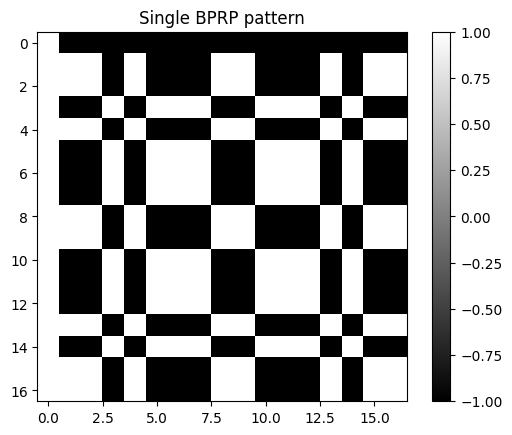

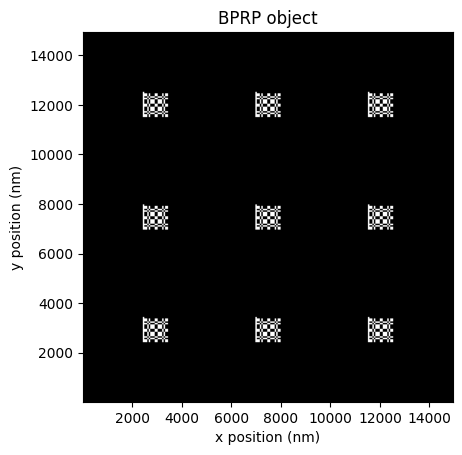

In [11]:
pattern = bprp(17, 17)
plt.imshow(pattern, cmap='gray')
plt.title('Single BPRP pattern')
plt.colorbar()
plt.show()


# BPRP size 17*60nm, corresponding to 17*4 pixels
magnified_pattern = np.kron(pattern+1, np.ones((4, 4)))

# 2.5um spacing between patterns
pattern_size = magnified_pattern.shape[0]
spacing = round(2.5e-6/dx_m) + pattern_size


obj_bprp = np.zeros((roi_size_px, roi_size_px))
width = 3*pattern_size + 2*spacing
shift = (roi_size_px - width) // 2
for i in range(3):
    for j in range(3):
        start_x = i * (pattern_size + spacing) + shift
        start_y = j * (pattern_size + spacing) + shift
        obj_bprp[start_x:start_x+pattern_size, start_y:start_y+pattern_size] = magnified_pattern


plt.imshow(obj_bprp, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('BPRP object')
plt.show()


## Create line object with roughness
return obj_lines

In [72]:
# initialize object
obj = np.ones((roi_size_px, roi_size_px))
roughness_nm = 0.2
obj_rough = obj * np.exp(1j * 2 * np.pi / lambda_m * 2 * roughness_nm * 1e-9 * np.random.randn(roi_size_px, roi_size_px))

# pitch size
p_nm = 4*dx_m*1e9
X_m, Y_m = np.meshgrid(x_m, y_m)
obj_lines = obj_rough * (1 + np.sign(np.sin(2 * np.pi * X_m / p_nm * 1e9)))


# Generate FPM measurements

## specify object

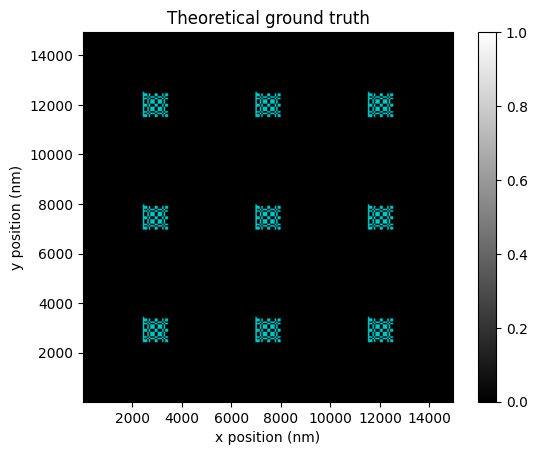

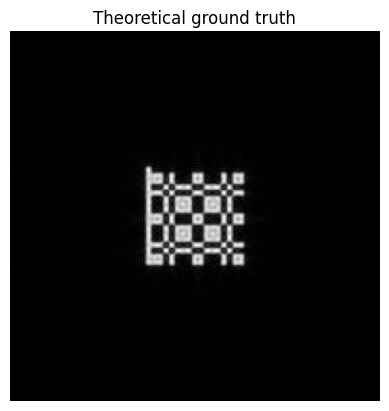

In [12]:
obj = obj_bprp
# normalize object
obj = obj / np.max(np.abs(obj))
img = np.abs(obj)**2

ideal_FILTER = (Fx**2 + Fy**2) <= ((1+np.sqrt(2))*fc_lens)**2
object_gt = ift(ft(obj)*ideal_FILTER)
img_gt = np.abs(object_gt)**2
img_lowres = np.abs(ift(ft(obj)*FILTER))**2

plt.imshow(imagecc(object_gt), extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Theoretical ground truth')
plt.colorbar()
plt.show()

# display the center [256, 256] region, total size roi_size_px
param_nx = 256
object_center = object_gt[roi_size_px//2-param_nx//2:roi_size_px//2+param_nx//2, roi_size_px//2-param_nx//2:roi_size_px//2+param_nx//2]
plt.imshow(np.abs(object_center), cmap='gray')
plt.axis('off')
plt.title('Theoretical ground truth')
plt.show()


In [10]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
NA = .33/4

for sx in Sx:
    for sy in Sy:
        X0 = round(fc_lens*Dx_m*sx/np.sqrt(NA**2*(sx**2+sy**2-1)+1))
        Y0 = round(fc_lens*Dx_m*sy/np.sqrt(NA**2*(sx**2+sy**2-1)+1))
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)

## Aberration free simulation

In [16]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_data/bprp_noabe/'
if not os.path.exists(folder):
    os.makedirs(folder)

I_low_stack = []
freqXY_calib = []
na_calib = []
na_cal = fc_lens*lambda_m
na_rp_cal = fc_lens*Dx_m
abe = get_pupil_phase(manual_defocus_z,FILTER)
abe_FILTER = FILTER*np.exp(1j*abe)

for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(abe_FILTER*circshift2(ft(obj), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # Fix global exposure
        img_angle = img_angle / 2 * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'fineline_infocus_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')
        I_low_stack.append(img_angle)
        na_calib.append([sx*fc_lens*lambda_m, sy*fc_lens*lambda_m])

np.save(f'{folder}/gt.npy', obj)
np.save(f'{folder}/gt_abe.npy', abe)
I_low = np.stack(I_low_stack, axis=2)
na_calib = np.array(na_calib)
freqXY_calib = na_calib*na_rp_cal/na_cal+roi_size_px/2+1

scipy.io.savemat(f'{folder}/bprp_noabe.mat', {'I_low': I_low, 'freqXY_calib': freqXY_calib, 'na_calib': na_calib, 'na_cal': na_cal, 'na_rp_cal': na_rp_cal})

## Aberratted simulation

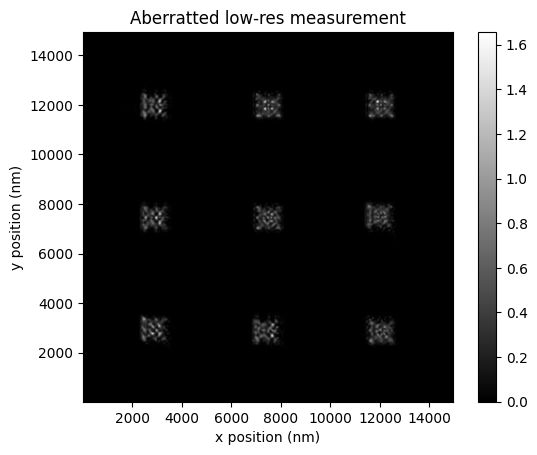

In [18]:
def forward(object, X0, Y0, FILTER=FILTER):
    obj_angle = np.zeros_like(object, dtype=np.complex128)
    for p in range(3):
        for q in range(3):
            abe = get_pupil_phase(p,q,FILTER)
            obj_patch = np.zeros_like(object)
            tile_size = 332
            obj_patch[p*tile_size:(p+1)*tile_size, q*tile_size:(q+1)*tile_size] = \
                object[p*tile_size:(p+1)*tile_size, q*tile_size:(q+1)*tile_size]
            abe_filter = FILTER*np.exp(1j*abe)
            obj_angle += ift(abe_filter * circshift2(ft(obj_patch), -X0, -Y0))
    img_angle = np.abs(obj_angle)**2
    return img_angle
                
img_angle = forward(obj, 0, 0)
plt.imshow(img_angle, extent=[x_m[0]*1e9, x_m[-1]*1e9, y_m[0]*1e9, y_m[-1]*1e9], cmap='gray')
plt.xlabel('x position (nm)')
plt.ylabel('y position (nm)')
plt.title('Aberratted low-res measurement')
plt.colorbar()
plt.show()


In [19]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_data/bprp_abe/'
if not os.path.exists(folder):
    os.makedirs(folder)

I_low_stack = []
freqXY_calib = []
na_calib = []
na_cal = fc_lens*lambda_m
na_rp_cal = fc_lens*Dx_m

for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        img_angle = forward(obj, X0, Y0)
        # scale by fixed exposure
        img_angle = img_angle / 2 * 255
        # print(np.max(img_angle))
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'aberrated_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')
        I_low_stack.append(img_angle)
        na_calib.append([-sx*fc_lens*lambda_m, -sy*fc_lens*lambda_m])

I_low = np.stack(I_low_stack, axis=2)
na_calib = np.array(na_calib)
freqXY_calib = na_calib*na_rp_cal/na_cal+roi_size_px/2+1

scipy.io.savemat(f'{folder}/bprp_abe.mat', {'I_low': I_low, 'freqXY_calib': freqXY_calib, 'na_calib': na_calib, 'na_cal': na_cal, 'na_rp_cal': na_rp_cal})

In [22]:
np.save(f'{folder}/gt.npy', obj)
np.save(f'{folder}/center_abe.npy', get_pupil_phase(1,1,FILTER))
# flip freqXY_calib along axis =1
freqXY_calib = np.flip(freqXY_calib, axis=1)
na_calib = np.flip(na_calib, axis=1)
scipy.io.savemat(f'{folder}/bprp.mat', {'I_low': I_low, 'freqXY_calib': freqXY_calib, 'na_calib': na_calib, 'na_cal': na_cal, 'na_rp_cal': na_rp_cal})

## (Optional) Include free-space propagation

In [18]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_data/defocus_5um/'
# free space propagation to the image plane
# defocus_m = 1e-6
# defocus_phase = np.exp(1j * 2 * np.pi * lambda_m * defocus_m * (Fx**2 + Fy**2))
# plt.imshow(np.angle(defocus_phase))
# plt.show()
obj_lines = np.load('./real_data/defocus_recon.npy')
obj_lines = obj_lines / np.max(obj_lines)

for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(FILTER*circshift2(ft(obj_lines), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # scale by fixed exposure
        img_angle = img_angle * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'defocus_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')

# np.save('./sim_data/obj_fineline.npy', obj_lines)

# Old simulation using self-specified Zernike
using ANSI Standard Zernikes

/var/folders/ck/jnrjwlt1209gwqhn1197cvpc0000gp/T/ipykernel_22579/1622836821.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coef = (-1)**s * np.math.factorial(n - s)
/var/folders/ck/jnrjwlt1209gwqhn1197cvpc0000gp/T/ipykernel_22579/1622836821.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coef /= np.math.factorial(s) * np.math.factorial((n + abs(m)) // 2 - s) * np.math.factorial((n - abs(m)) // 2 - s)


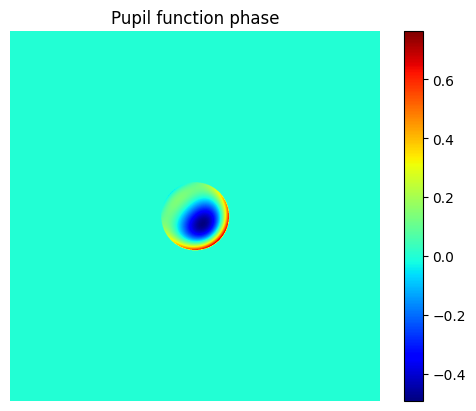

In [38]:
def zernike_polynomial(n, m, pupil):
    def polar_coords():
        """Generate polar coordinates for a given size"""
        x = np.linspace(-1, 1, cmax-cmin+1)
        y = np.linspace(-1, 1, rmax-rmin+1)
        X, Y = np.meshgrid(x, y)
        R = np.sqrt(X**2 + Y**2)
        T = np.arctan2(Y, X)
        T = np.where(T < 0, T + 2*np.pi, T)
        return R, T

    def radial_poly(n, m, R):
        """Calculate the radial polynomial"""
        radial = np.zeros_like(R)
        for s in range((n - abs(m)) // 2 + 1):
            coef = (-1)**s * np.math.factorial(n - s)
            coef /= np.math.factorial(s) * np.math.factorial((n + abs(m)) // 2 - s) * np.math.factorial((n - abs(m)) // 2 - s)
            radial += coef * R**(n - 2 * s)
        return radial

    rows = np.any(pupil, axis=1)
    cols = np.any(pupil, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    R, T = polar_coords()
    Radial = radial_poly(n, m, R)
    if m > 0:
        Z = np.sqrt(2*n+2) * Radial * np.cos(m * T)
    elif m < 0:
        Z = -np.sqrt(2*n+2) * Radial * np.sin(m * T)
    else:
        Z = np.sqrt(n+1) * Radial

    # Pad the Zernike polynomial to match the full pupil size
    padded_Z = np.zeros(pupil.shape)
    padded_Z[rmin:rmax+1, cmin:cmax+1] = Z
    return padded_Z

defocus_coef = 0.2
coma_coef = [0.1,0.1]
defocus = zernike_polynomial(2, 0, FILTER)
coma1 = zernike_polynomial(3, 1, FILTER)
coma2 = zernike_polynomial(3, -1, FILTER)
aberration = (defocus_coef*defocus+ coma_coef[0]*coma1 + coma_coef[1]*coma2)*FILTER
aberrated_FILTER = FILTER * np.exp(1j*aberration)

plt.imshow(np.angle(aberrated_FILTER), cmap='jet')
plt.title('Pupil function phase')
plt.axis('off')
plt.colorbar()
plt.show()


/var/folders/ck/jnrjwlt1209gwqhn1197cvpc0000gp/T/ipykernel_22579/1622836821.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coef = (-1)**s * np.math.factorial(n - s)
/var/folders/ck/jnrjwlt1209gwqhn1197cvpc0000gp/T/ipykernel_22579/1622836821.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coef /= np.math.factorial(s) * np.math.factorial((n + abs(m)) // 2 - s) * np.math.factorial((n - abs(m)) // 2 - s)


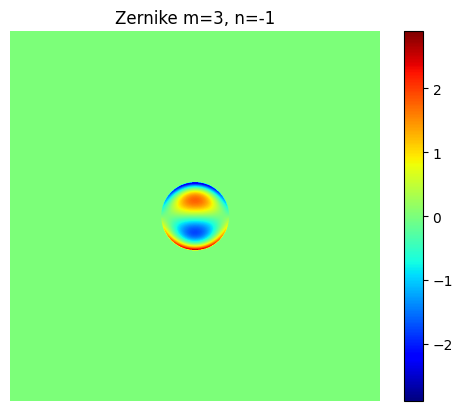

In [41]:
defocus_coef = 0
coma_coef = [0,1]
defocus = zernike_polynomial(2, 0, FILTER)
coma1 = zernike_polynomial(3, 1, FILTER)
coma2 = zernike_polynomial(3, -1, FILTER)
aberration = (defocus_coef*defocus+ coma_coef[0]*coma1 + coma_coef[1]*coma2)*FILTER

plt.imshow(aberration, cmap='jet')
plt.title('Zernike m=3, n=-1')
plt.axis('off')
plt.colorbar()
plt.show()

# Generate aberrated FPM measurements

In [42]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_data/'
for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(aberrated_FILTER*circshift2(ft(obj_lines), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # scale by fixed exposure
        img_angle = img_angle / 8 * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'./abe_invariant/aberrated_fineline_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')

np.save('./sim_data/obj_fineline.npy', obj_lines)
np.save('./sim_data/pupil_function.npy', aberrated_FILTER)

# Spatial variant aberration

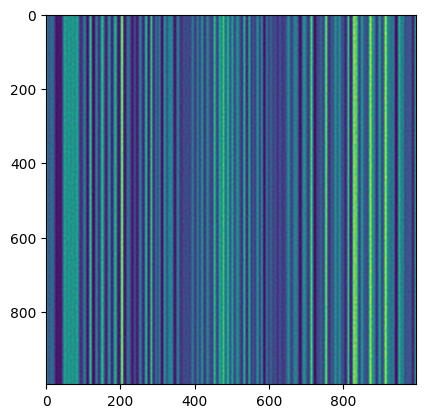

In [20]:
def forward(object, X0, Y0, FILTER=FILTER):
    obj_angle = np.zeros_like(object)
    for p in range(5,9):
        for q in range(5,9):
            abe = get_pupil(6,6, FILTER)*5
            obj_patch = np.zeros_like(object)
            obj_patch[p*256:(p+1)*256, q*256:(q+1)*256] = object[p*256:(p+1)*256, q*256:(q+1)*256]
            # pad abe to object size
            pad1 = (obj.shape[0]-abe.shape[0])//2
            pad2 = (obj.shape[0]-abe.shape[0]) - pad1
            abe_pad = np.pad(abe, ((pad1, pad2), (pad1, pad2)), 'constant', constant_values=0)
            abe_filter = FILTER*np.exp(1j*abe_pad)
            obj_angle += ift(abe_filter * circshift2(ft(object), -X0, -Y0))
    img_angle = np.abs(obj_angle)**2
    return img_angle
                
img_angle = forward(obj_lines, 0, 0)
plt.imshow(img_angle)
plt.show()


# Sx = np.linspace(-1,1,9)
# Sy = np.linspace(-1,1,9)
# folder = './sim_data/'
# for sx in Sx:
#     for sy in Sy:
#         X0 = round(sx*fc_lens*Dx_m)
#         Y0 = round(sy*fc_lens*Dx_m)
#         img_angle = forward(obj_lines, X0, Y0)
#         # scale by fixed exposure
#         img_angle = img_angle * 8 * 255
#         print(np.max(img_angle))
#         sx_str = str(sx).zfill(5)
#         sy_str = str(sy).zfill(5)
#         filename = f'aberrated_fineline_{sx_str}_data_{sy_str}.png'
#         img_pil = Image.fromarray(np.uint8(img_angle))
#         img_pil.save(f'{folder}/{filename}')



# Generate anime object

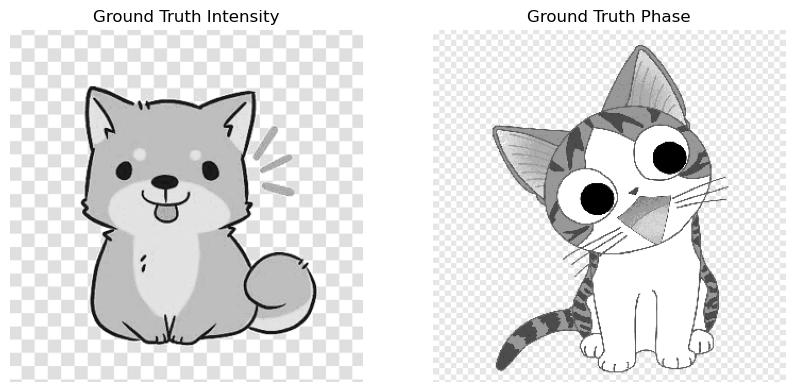

In [21]:
intensity = Image.open('intensity.png')
intensity = intensity.resize((roi_size_px, roi_size_px))
intensity = np.asarray(intensity.convert('L'))/255

phase = Image.open('phase.png')
phase = phase.resize((roi_size_px, roi_size_px))
phase = np.asarray(phase.convert('L'))/255*np.pi

obj_anime = intensity * np.exp(1j*phase)


# Create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Display the image
ax[0].imshow(np.abs(obj_anime), cmap='gray')
ax[1].imshow(np.angle(obj_anime), cmap='gray')

# Hide the axes
ax[0].axis('off')
ax[1].axis('off')

# Add titles
ax[0].set_title('Ground Truth Intensity')
ax[1].set_title('Ground Truth Phase')

# Show the plot
plt.show()


In [25]:
Sx = np.linspace(-1,1,9)
Sy = np.linspace(-1,1,9)
folder = './sim_anime'
for sx in Sx:
    for sy in Sy:
        X0 = round(sx*fc_lens*Dx_m)
        Y0 = round(sy*fc_lens*Dx_m)
        obj_angle = ift(aberrated_FILTER*circshift2(ft(obj_anime), -X0, -Y0))
        img_angle = np.abs(obj_angle)**2
        # scale by fixed exposure
        img_angle = img_angle / 3 * 255
        sx_str = str(sx).zfill(5)
        sy_str = str(sy).zfill(5)
        filename = f'aberrated_line_{sx_str}_data_{sy_str}.png'
        img_pil = Image.fromarray(np.uint8(img_angle))
        img_pil.save(f'{folder}/{filename}')

np.save('obj_anime.npy', obj_anime)
np.save('pupil_function.npy', aberrated_FILTER)